In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ParameterGrid, cross_validate
import nltk
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn import decomposition
import pandas as pd
from copy import deepcopy
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools
import random
import warnings
import string
from shutil import copyfile
warnings.filterwarnings("ignore", category=UserWarning)

from functions import *


### Define Variables

In [18]:
global_shuffle_seed = 4
global_debug=True
global_override=True

### Load tagtog Data

In [19]:
result, clf_result = {}, {}
df_data = load_data_tagtog(['../tagtog/output'])
df_data = df_data[df_data['is_flood'].notna()]
data_true = query_dataframe(df_data, {'is_flood':True})
data_false = query_dataframe(df_data, {'is_flood':False})
print('Total:',len(df_data),'True:',len(data_true), 'False:',len(data_false))

Total: 1597 True: 858 False: 739


### Preprocess Data

In [20]:
# Let's consider with and without stop words

custom_stop_words = set(['date', 'published'])
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)
all_stop_words = stop_words.union(punctuations, custom_stop_words)
def preprocess(x):
    x = re.sub('[^a-z\s]', ' ', x.lower())
    x = [w for w in x.split() if w not in all_stop_words and len(w)>3]
    return ' '.join(x)

In [21]:
df_data['org_text'] = df_data['text']
df_data['text'] = df_data['text'].apply(preprocess)

## Size and Ratio Exploration

In [22]:
n = 40
#df_data["text"][n], df_data["org_text"][n]
floodArticles = df_data[df_data["is_flood"] == True]
nonfloodArticles = df_data[df_data["is_flood"] == False]

In [23]:
print("Newspaper splits")
def newspaperCounts(df_data):
    return [(t, sum(df_data['newspaper'].notna()) if t==None else sum(df_data['newspaper']==t)) for t in set(df_data['newspaper'])]

print("All", newspaperCounts(df_data))
print("Flood", newspaperCounts(floodArticles))
print("Not Flood", newspaperCounts(nonfloodArticles))

Newspaper splits
All [('daily_star', 324), ('dhaka_tribune', 443), (None, 973), ('ny_times', 206)]
Flood [('daily_star', 153), ('dhaka_tribune', 108), (None, 301), ('ny_times', 40)]
Not Flood [('daily_star', 171), ('dhaka_tribune', 335), (None, 672), ('ny_times', 166)]


The average size of the text is 317.0 with deviation 257.0
For unnassociated newspapers the average size of the text is 350.0 with deviation 296.0
For daily_star newspapers the average size of the text is 355.0 with deviation 222.0
For dhaka_tribune newspapers the average size of the text is 253.0 with deviation 173.0
For ny_times newspapers the average size of the text is 549.0 with deviation 461.0
For unnassociated flood newspapers the average size of the text is 300.0 with deviation 172.0
For daily_star flood newspapers the average size of the text is 322.0 with deviation 172.0
For dhaka_tribune flood newspapers the average size of the text is 274.0 with deviation 148.0
For ny_times flood newspapers the average size of the text is 287.0 with deviation 215.0


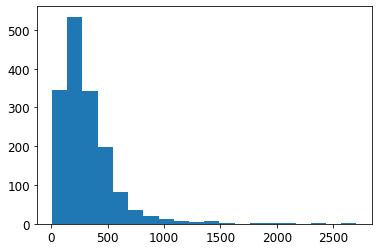

In [24]:
def getWordCountStats(df):
    counts = df.apply(lambda txt: len(txt.split(" ")))
    return counts, round(np.mean(counts)), round(np.std(counts))

counts, mu, std = getWordCountStats(df_data["text"])

restrictions = [("unnassociated", df_data['newspaper'].notna())] 
restrictions += [(t, df_data['newspaper']==t) for t in set(df_data['newspaper']) if t !=None]
restrictions += [(name + " flood", filt & df_data["is_flood"]==True) for name, filt in restrictions]

print("The average size of the text is {} with deviation {}".format(mu, std))

for name, filt in restrictions:
    _, mu, std = getWordCountStats(df_data[filt]["text"])
    print("For {} newspapers the average size of the text is {} with deviation {}".format(name, mu, std))

plt.hist(counts, bins = 20)
plt.show()

### Split Data

In [25]:
def make_data_ratio(df_data, test_size=None, train_size=None, shuffle_seed=4, debug=False, 
                    save_folder=None, load_folder=None, override=False, file_prefix=''):
    save_file, load_file=None, None
    if save_folder: save_file = os.path.join(save_folder,file_prefix+'data.json')
    if load_folder: load_file = os.path.join(load_folder,file_prefix+'data.json')
    
    if not override and load_file and os.path.isfile(load_file):
        if debug: print('loaded',load_file)
        js = json.load(open(load_file))
        train_df = pd.DataFrame(js['train'])
        test_df = pd.DataFrame(js['test'])
        return {'train':train_df, 'test':test_df}
    
    train_df, test_df = train_test_split(df_data, test_size=test_size, train_size=train_size, random_state=shuffle_seed, stratify=df_data['is_flood'])
    
#     true_data = df_data.loc[df_data['is_flood']==True]
#     false_data = df_data.loc[df_data['is_flood']==False]
#     train_true, test_true = train_test_split(true_data, test_size=test_size, random_state=shuffle_seed)
#     train_false, test_false = train_test_split(false_data, test_size=test_size, random_state=shuffle_seed)
    
#     train_df = pd.concat([train_true, train_false])
#     train_df = train_df.sample(n=len(train_df), random_state=shuffle_seed).reset_index(drop=True)
#     test_df = pd.concat([test_true, test_false])
#     test_df = test_df.sample(n=len(test_df), random_state=shuffle_seed).reset_index(drop=True)
    
    if debug: print('Data Loaded')

    if save_file:
        train_json = train_df.to_json(orient='records')
        test_json = test_df.to_json(orient='records')
        json.dump({'train':json.loads(train_json), 'test':json.loads(test_json)}, open(save_file,'w'), indent=2)
    return {'train':train_df, 'test':test_df}


In [26]:
result, clf_result = {}, {}
save_data_folder = 'data_splits/'
load_data_folder = 'data_splits/'
test_size = 0.2
if not os.path.isdir(save_data_folder): os.mkdir(save_data_folder)
debug=global_debug or False
override=global_override or False
data_split = make_data_ratio(df_data, test_size=test_size, save_folder=save_data_folder, load_folder=load_data_folder, 
                               debug=debug, shuffle_seed=global_shuffle_seed, override=override)


Data Loaded


In [27]:
print('Train:',len(data_split['train']), '\t\tTest:',len(data_split['test']))
print('Train is_flood:',len(data_split['train'].loc[data_split['train']['is_flood']==True]), \
'\tTrain not is_flood:',len(data_split['train'].loc[data_split['train']['is_flood']==False]))
print('Test is_flood:',len(data_split['test'].loc[data_split['test']['is_flood']==True]), \
'\tTest not is_flood:',len(data_split['test'].loc[data_split['test']['is_flood']==False]))

Train: 1277 		Test: 320
Train is_flood: 686 	Train not is_flood: 591
Test is_flood: 172 	Test not is_flood: 148


### Classifier

In [28]:
def make_data(vect_fit, ratio):
    train, test = ratio.get('train',None), ratio.get('test',None)
    if train is None or test is None: raise Exception('Train or Test data not found')
    all_X = list(train['text'])
    
    vect = vect_fit.fit(all_X)
    trainX, testX = vect.transform(list(train['text'])), vect.transform(list(test['text']))
    trainY, testY = [1 if t else 0 for t in train['is_flood']], [1 if t else 0 for t in test['is_flood']]
    return trainX, testX, trainY, testY, vect


In [29]:
trainX, testX, trainY, testY, vectorizer = make_data(TfidfVectorizer(), data_split)
trainX.shape

(1277, 28650)

### Quick Naive Bayes Model with TfIdf Vectorizer

In [31]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_clf = MultinomialNB().fit(trainX, trainY)

feature_names = np.array(vectorizer.get_feature_names())
odds = np.argsort(naive_bayes_clf.feature_log_prob_[0, :]/naive_bayes_clf.feature_log_prob_[1, :])

print("Words frequencies predicting flood articles: ")
print(", ".join(feature_names[odds[:-10:-1]]))

print("\nWords frequencies predicting non-flood articles: ")
print(", ".join(feature_names[odds[:10]]))

print("\nAccuracy is {}".format(accuracy_score(testY, naive_bayes_clf.predict(testX))))

Words frequencies predicting flood articles: 
flowing, danger, flooded, inundated, marooned, upazilas, erosion, floods, affected

Words frequencies predicting non-flood articles: 
coronavirus, bangabandhu, york, world, economic, growth, countries, election, trade, american

Accuracy is 0.884375


### Decision Tree with TfIdf Vectorizer

In [32]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(trainX, trainY)

DecisionTreeClassifier()

In [33]:
accuracy_score(testY, clf.predict(testX))

0.88125

In [34]:
def run_classifier(clf, trainX, testX, trainY, testY):
    clf_fit = clf.fit(trainX, trainY)
    clf_pred = clf_fit.predict(testX)
    clf_acc = accuracy_score(testY, clf_pred)
    return clf_fit, clf_pred, clf_acc

In [35]:
def get_method(main_d, name):
    if name not in main_d: raise Exception('Cannot find classifier/feature_extractor name in parameter dictionary')
    d = main_d[name]
    method = d.get('method',None)
    base_method = d.get('base_method',None)
    if method and base_method: raise Exception('Cannot have method and base method both.')
    if not method and not base_method: raise Exception('Unable to parse the method from classifier/feature_extractor')
    params = d.get('params',None)
    if method:
        if params: return method, params
        else: return method, None
    if base_method:
        prev_method, prev_params = get_method(main_d, base_method)
        if params:
            for k,v in params.items(): prev_params[k] = v
        return prev_method, prev_params

def make_method(main_d, name, override_params={}):
    method, params = get_method(main_d, name)[:]
    if override_params:
        for k,v in override_params.items(): params[k] = v
    if params: return method(**params)
    else: return method()

In [36]:
def run_grid(grid, data, feature_extract, classifiers, clf_result, result, 
             debug=False, override=False, save_folder=None, load_folder=None, file_prefix=''):
    save_clf_result = {}
    vectCache, classifierCache = {}, {}
    if load_folder:
        res_file = os.path.join(load_folder,file_prefix+'clf_result.json')
        clf_res_file = os.path.join(load_folder,file_prefix+'result.json')
        if os.path.isfile(res_file): clf_result=json.load(open(res_file))
        if os.path.isfile(clf_res_file): result=json.load(open(clf_res_file))
        if os.path.isfile(res_file) and os.path.isfile(clf_res_file) and debug: print('loaded result')
    
    if override:
        clf_result, result = {}, {}
        if debug: print('OVERRIDE')
    for g in list(grid):
        try:
            feature_name = g.get('feature_extract',None)
            clf_name = g.get('classifier', None)
            if not feature_name or not clf_name:
                raise Exception('Feature Extract and Classifier Name required')
            result_key = feature_name + '-' + clf_name
            if result.get(result_key): continue
            if debug: print('Feature:', feature_name, '  Clasifier:',clf_name, '  Key:',result_key)
            
            if feature_name in vectCache:
                (trainX, testX, trainY, testY, feature2) = vectCache[feature_name]
            else:
                feature = make_method(feature_extract, feature_name)
                trainX, testX, trainY, testY, feature2 = make_data(feature, data)
                vectCache[feature_name] = (trainX, testX, trainY, testY, feature2)

            clf = make_method(classifiers, clf_name)
            clf_fit, clf_pred, clf_acc = run_classifier(clf, trainX, testX, trainY, testY)
            
            result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'accuracy': clf_acc
            }
            
            clf_result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'clf': clf_fit,
                'feature': feature2,
                'predict': clf_pred
            }
            
            save_clf_result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'predict': clf_pred.tolist()
            }  
        except Exception as e:
            print('Error:',e)
            continue
    if save_folder:
        json.dump(save_clf_result, open(os.path.join(load_folder,file_prefix+'clf_result.json'),'w'), indent=2)
        json.dump(result, open(os.path.join(load_folder,file_prefix+'result.json'),'w'), indent=2)
    return clf_result, result


In [104]:
def run_grid_cross_validate(grid, data, feature_extract, classifiers, result, debug=False):
    for g in list(grid):
        feature_name = g.get('feature_extract',None)
        clf_name = g.get('classifier', None)
        if not feature_name or not clf_name:
            raise Exception('Feature Extract and Classifier Name required')
        result_key = feature_name + '-' + clf_name
        if result.get(result_key): continue
        if debug: print('Feature:', feature_name, '  Clasifier:',clf_name, '  Key:',result_key)

        feature = make_method(feature_extract, 'TFIDF')
        all_X = data['text']
        all_Y = data['is_flood']
        vect = feature.fit(all_X)
        x, y = vect.transform(list(all_X)), [1 if t else 0 for t in all_Y]
        clf = make_method(classifiers, clf_name)
        cv = cross_validate(clf, x, y, cv=5,
                      scoring=('accuracy', 'precision', 'recall', 'f1'))
        result[result_key] = cv
    return result

In [105]:
def parse_result(result, clf_result=None, data=None, accuracy_threshold=None, split_by='classifier'):
    keys = list(result.keys())
    temp_df = pd.DataFrame(list(result.values()))
    if clf_result is not None and data is not None:
        presicion, recall, f1, support = [], [], [], []
        actual = [1 if f else 0 for f in list(data['test']['is_flood'])]
        for method_name in keys:
            predict = clf_result[method_name]['predict']
            pre, rec, fsc, sup = precision_recall_fscore_support(actual, predict, average='binary')
            presicion.append(pre)
            recall.append(rec)
            f1.append(fsc)
            support.append(sup)
        temp_df['f1'] = f1
        temp_df['presicion'] = presicion
        temp_df['recall'] = recall
#     temp_df['keys'] = keys
    splt_val = list(set(list(temp_df[split_by])))
    for d in splt_val:
        if accuracy_threshold:
            new_df = temp_df.loc[temp_df[split_by]==d]
            new_df = new_df.loc[new_df['accuracy']>accuracy_threshold] \
                            .drop(split_by, axis=1) \
                            .sort_values(by='accuracy',ascending=False) \
                            .reset_index(drop=True)
        else:
            new_df = temp_df.loc[temp_df[split_by]==d] \
                            .drop(split_by, axis=1) \
                            .sort_values(by='accuracy',ascending=False) \
                            .reset_index(drop=True)
        print('{}: {}'.format(split_by,d))
        print(new_df.to_markdown())
        print()

In [108]:
def make_vocab(ratio):
    train, test = ratio.get('train',None), ratio.get('test',None)
    if train is None or test is None: raise Exception('Train or Test data not found')
    all_X = list(train['text']) + list(test['text'])
    
    params= {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
        }
    vect = CountVectorizer(**params)
    vect = vect.fit(all_X)
    return list(vect.vocabulary_.keys())

In [109]:
# Logistic Regression
vocab = make_vocab(data_split)
feature_extract = {
    'CountVect': {
        'classifier_type': 'Count Vectorizer',
        'method': CountVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    },
    'CountVect-2gram':{
        'base_method': 'CountVect',
        'params':{
            'ngram_range':(1,2)
        }
    },
    'CountVect-min_df-max_df':{
        'base_method': 'CountVect',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
    'CountVect-2gram-min_df-max_df':{
        'base_method': 'CountVect',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95,
            'ngram_range':(1,2)
        }
    },
    'TFIDF': {
        'classifier_type': 'TFIDF',
        'method': TfidfVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    },
    'TFIDF-2gram':{
        'base_method': 'TFIDF',
        'params':{
            'ngram_range':(1,2)
        }
    },
    'TFIDF-min_df-max_df':{
        'base_method': 'TFIDF',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
    'TFIDF-2gram-min_df-max_df':{
        'base_method': 'TFIDF',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95,
            'ngram_range':(1,2)
        }
    }
}

classifiers = {
    'RandomForest': {
        'classifier_type':'Random Forest ',
        'method': RandomForestClassifier,
        'params':{
            'class_weight':'balanced'
        }
    },
    'LinearSVC': {
        'classifier_type': 'Linear SVC',
        'method': LinearSVC,
        'params':{
            'class_weight':'balanced'
        }
    },
    'LogRegL1':{
        'classifier_type': 'Logistic Regression L1',
        'method': LogisticRegression,
        'params':{
            'penalty': 'l1',
            'class_weight':'balanced',
            'solver': 'liblinear',
            'max_iter': 1000
        }
    },
    'LogRegL2':{
        'classifier_type': 'Logistic Regression L2',
        'method': LogisticRegression,
        'params':{
            'penalty': 'l2',
            'class_weight':'balanced',
            'solver': 'liblinear',
            'max_iter': 1000
        }
    }
}

grid_parameters = {
    'feature_extract': list(feature_extract.keys()),
    'classifier': list(classifiers.keys()),
}

grid = ParameterGrid(grid_parameters)

In [112]:
override=global_override or False
debug=global_debug or False
save_results_folder = 'results/'
load_results_folder = 'results/'
if not os.path.isdir(save_results_folder): os.mkdir(save_results_folder)
clf_result, result = run_grid(grid, data_split, feature_extract, classifiers, clf_result, result, 
                              debug=debug, override=override, save_folder=save_results_folder, 
                             load_folder=load_results_folder)

OVERRIDE
Feature: CountVect   Clasifier: RandomForest   Key: CountVect-RandomForest
Feature: CountVect-2gram   Clasifier: RandomForest   Key: CountVect-2gram-RandomForest
Feature: CountVect-min_df-max_df   Clasifier: RandomForest   Key: CountVect-min_df-max_df-RandomForest
Feature: CountVect-2gram-min_df-max_df   Clasifier: RandomForest   Key: CountVect-2gram-min_df-max_df-RandomForest
Feature: TFIDF   Clasifier: RandomForest   Key: TFIDF-RandomForest
Feature: TFIDF-2gram   Clasifier: RandomForest   Key: TFIDF-2gram-RandomForest
Feature: TFIDF-min_df-max_df   Clasifier: RandomForest   Key: TFIDF-min_df-max_df-RandomForest
Feature: TFIDF-2gram-min_df-max_df   Clasifier: RandomForest   Key: TFIDF-2gram-min_df-max_df-RandomForest
Feature: CountVect   Clasifier: LinearSVC   Key: CountVect-LinearSVC
Feature: CountVect-2gram   Clasifier: LinearSVC   Key: CountVect-2gram-LinearSVC
Feature: CountVect-min_df-max_df   Clasifier: LinearSVC   Key: CountVect-min_df-max_df-LinearSVC
Feature: CountVe